# Conditional Random Field

In [1]:
import matplotlib.pyplot as plt
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

%matplotlib inline

In [2]:
test_sents = []

with open('dataset/eng.testa') as data_file:
    data = data_file.readlines()
    sentences = []
    for line in data:
        item = line.split()
        try:
            if item[0] == '-DOCSTART-':
                break
            del item[2]
        except:
            test_sents.append(sentences.copy())
            sentences = []
            continue
        sentences.append(item)


train_sents = []        

with open('dataset/eng.testb') as data_file:
    data = data_file.readlines()
    sentences = []
    for line in data:
        item = line.split()
        try:
            if item[0] == '-DOCSTART-':
                break
            del item[2]
        except:
            test_sents.append(sentences.copy())
            sentences = []
            continue
        sentences.append(item)
        
with open('dataset/eng.train') as data_file:
    data = data_file.readlines()
    sentences = []
    for line in data:
        item = line.split()
        try:
            if item[0] == '-DOCSTART-':
                break
            del item[2]
        except:
            train_sents.append(sentences.copy())
            sentences = []
            continue
        sentences.append(item)

In [3]:
train_sents[0]

[['EU', 'NNP', 'I-ORG'],
 ['rejects', 'VBZ', 'O'],
 ['German', 'JJ', 'I-MISC'],
 ['call', 'NN', 'O'],
 ['to', 'TO', 'O'],
 ['boycott', 'VB', 'O'],
 ['British', 'JJ', 'I-MISC'],
 ['lamb', 'NN', 'O'],
 ['.', '.', 'O']]

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features ={
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2]
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][0]
        features.update({
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2]
        })
    else:
        features['BOS'] = True
        
    if i < len(sent) - 1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][0]
        features.update({
            '+1:word.isupper()': word1.isupper(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isdigit()': word1.isdigit(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2]
        })
    else:
        features['EOS'] = True
        
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [5]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'eu',
 'word[-3:]': 'EU',
 'word[-2:]': 'EU',
 'word.isupper()': True,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'NNP',
 'postag[:2]': 'NN',
 'BOS': True,
 '+1:word.isupper()': False,
 '+1:word.istitle()': False,
 '+1:word.isdigit()': False,
 '+1:postag': 'rejects',
 '+1:postag[:2]': 're'}

In [6]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 3.26 ms


In [7]:
%time
crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
crf.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [8]:
labels = list(crf.classes_)
labels.remove('O')
labels

['I-ORG', 'I-MISC', 'I-PER', 'I-LOC']

In [9]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.38833770512393184

In [10]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       I-LOC      0.579     0.344     0.431        32
      I-MISC      0.000     0.000     0.000        20
       I-ORG      0.105     0.080     0.091        25
       I-PER      0.705     0.674     0.689        46

   micro avg      0.524     0.358     0.425       123
   macro avg      0.347     0.274     0.303       123
weighted avg      0.436     0.358     0.388       123



In [11]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s


CPU times: user 6.38 s, sys: 94.8 ms, total: 6.48 s
Wall time: 7.1 s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.0s finished
/home/praneet/venv/blackstraw/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa17d6cc048>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa17d6cc1d0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_sco

In [12]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.22488954193744476, 'c2': 0.0007106192427788461}
best CV score: 0.5991030708422013
model size: 0.01M


Dark blue => 0.2804, dark red => 0.5991


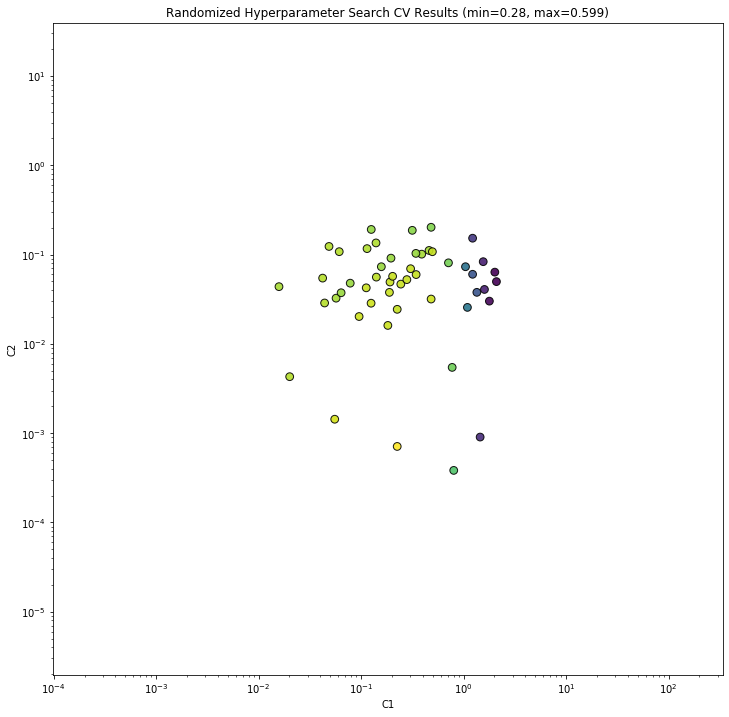

In [13]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]

_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [14]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       I-LOC      0.417     0.625     0.500        32
      I-MISC      0.000     0.000     0.000        20
       I-ORG      0.071     0.080     0.075        25
       I-PER      0.673     0.717     0.695        46

   micro avg      0.440     0.447     0.444       123
   macro avg      0.290     0.356     0.318       123
weighted avg      0.375     0.447     0.405       123



/home/praneet/venv/blackstraw/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-PER  -> I-PER   4.483268
I-ORG  -> I-ORG   3.827149
I-MISC -> I-MISC  2.644557
I-LOC  -> O       0.284173
O      -> O       0.004285
I-PER  -> O       -0.360639

Top unlikely transitions:
I-PER  -> I-PER   4.483268
I-ORG  -> I-ORG   3.827149
I-MISC -> I-MISC  2.644557
I-LOC  -> O       0.284173
O      -> O       0.004285
I-PER  -> O       -0.360639


In [16]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
8.375494 O        bias
7.943271 O        -1:postag:Farm
6.072913 I-MISC   word[-3:]:ish
5.402913 I-MISC   word.lower():german
2.817113 I-ORG    word[-3:]:ion
2.396439 I-PER    word[-2:]:er
2.205688 I-ORG    word.isupper()
2.146776 O        word[-3:]:arm
2.112743 O        word.lower():farm
1.939915 I-PER    word.lower():fischler
1.939915 I-PER    word[-3:]:ler
1.700428 O        word[-3:]:day
1.700428 O        word[-2:]:ay
1.590419 I-ORG    +1:postag:Union
1.590419 I-ORG    +1:postag[:2]:Un
1.532721 I-MISC   word.lower():bse
1.532721 I-MISC   word[-3:]:BSE
1.532721 I-MISC   word[-2:]:SE
1.404222 I-ORG    word.lower():radio
1.404222 I-ORG    word[-3:]:dio
1.404222 I-ORG    -1:postag:BBC
1.404222 I-ORG    -1:postag[:2]:BB
1.243271 I-LOC    word.lower():britain
1.243271 I-LOC    word[-3:]:ain
1.225572 I-LOC    BOS
1.209149 I-PER    +1:postag[:2]:Pa
1.192694 O        word[-2:]:ch
1.188353 I-LOC    word[-2:]:in
1.153080 I-ORG    word.lower():eu
1.153080 I-ORG    word[-3:]:EU

To